# Python and Sionna RT Environment Config

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sionna
from sionna.rt import load_scene
from matplotlib.colors import ListedColormap
import importlib
import SceneConfigSionna  
import BeamformingCalc
importlib.reload(SceneConfigSionna) 
importlib.reload(BeamformingCalc) 
from SceneConfigSionna import SceneConfigSionna
from BeamformingCalc import svd_bf, nulling_bf
import random
from scipy.stats import chi2

✅ Using GPU: /physical_device:GPU:0
✅ Using GPU: /physical_device:GPU:0


In [2]:
# scenegen bbox -105.097 40.0371 -105.06 40.0697 --data-dir scenes/Denver
# scene = load_scene("../Denver/denver.xml")
# scene = load_scene("../Denver_Scene/Boulder2_2/Boulder2.xml")
# scene = load_scene("../blouder_plane_itu3/boulder_plane_itu.xml")
scene = load_scene("Denver_Scene/Boulder/Boulder.xml")

Parmeters

In [ ]:
n_sim = 20
nbs = 1
nsect = 3
# ntn_rx=300
ntn_rx=30
tn_rx=500
bs_dist_min=35
bs_dist_max=3000

tx_antenna_rows = 4
tx_antenna_cols = 16
tn_rx_antenna_rows = 1
tn_rx_antenna_cols = 1
tx_antennas = tx_antenna_rows*tx_antenna_cols
tn_antennas = tn_rx_antenna_rows*tn_rx_antenna_cols



EkT = -174    # Noise energy in dBm/Hz, antenna temperature for vsat: 290K
B = 100e6
Tx_power_dbm = 30 # dbm
Tx_power = 10 ** ((Tx_power_dbm - 30) / 10)

NF = 7  # Noise figure in dB
NF_vsat = 3
NF_bs = 2
# reference signal duration
preamble_time = 20e-6 
N0_dBm = EkT + 10 * np.log10(B) + NF
N0 = 10 ** ((N0_dBm - 30) / 10)
N0_vsat =  10 ** ((EkT + 10 * np.log10(B) + NF_vsat - 30) / 10)
N0_bs =  10 ** ((EkT + 10 * np.log10(B) +NF_bs - 30) / 10)

# For channel estimation interference distribution, h_hat = h + CN~(0, N0/(Tx_power*time))

N0_sigma =  10 ** ((EkT  +NF_bs - 30) / 10) /Tx_power/preamble_time




snr_threshold = -6  # SNR threshold in dB
inr_threshold = -6
h_ntn_snr_th = np.sqrt(10**(inr_threshold/10)*N0_bs*tx_antennas /Tx_power)
h_tn_th = np.sqrt(10**(snr_threshold/10)*N0_bs*tx_antennas /Tx_power)
# Threshold = 10*np.log10(np.abs(h_tn_th)**2)
p_fa = 1/B
pfa_treshold =  chi2.ppf(1 - p_fa, 2 * tx_antennas) / 2  # t = Z/2
# pfa_treshold = 50
h_ntn_pfa_th =np.sqrt(pfa_treshold*N0_sigma)
Threshold = 10*np.log10(np.abs(h_ntn_pfa_th)**2)

print(f"h_ntn_snr_th (from SNR threshold): {h_ntn_snr_th:.4e}")
print(f"p_fa (false alarm rate): {p_fa:.2e}")
print(f"pfa_treshold(t) (false alarm rate): {pfa_treshold}")
print(f"h_ntn_pfa_th (from chi² Pfa threshold): {h_ntn_pfa_th}")
print(f"h_ntn_pfa_th (in dB): {Threshold }")

h_ntn_snr_th (from SNR threshold): 3.1849e-06
p_fa (false alarm rate): 1.00e-08
pfa_treshold(t) (false alarm rate): 59.740754346569844
h_ntn_pfa_th (from chi² Pfa threshold): 0.0013728413549961868
h_ntn_pfa_th (in dB): -57.24759293524356


In [18]:
p_fa = 1/B
pfa_treshold =  chi2.ppf(1 - p_fa, 2 * tx_antennas) / 2  # t = Z/2
print(f"pfa_treshold(t) : {pfa_treshold}")

pfa_treshold(t) : 119.48150869313969


In [24]:
# D = 2500
# lam = 3e8/10e9
# print(N0_dBm)
# pl = 20*np.log10(lam/4/np.pi/D)
# # pl
# ptx = 30
# bf = 10*np.log10(64)
# snr = ptx+pl-N0_dBm+bf
# print(snr)

Run Simu

In [43]:
interference_ntn = 0   
Used_tn = 0   
total_ntn = 0

inr_list = []


snr_list = []
Q_1_dB_list = []
h_ntn_dB_list = []
h_tn_dB_list = []
lambda_ranges = [1e10,1e11,1e12] 
eigen_value_dict = {l: [] for l in lambda_ranges}
snr_nulling_dict = {l: [] for l in lambda_ranges}
snr_nulling_hat_dict = {l: [] for l in lambda_ranges}
snr_degration_dict = {l: [] for l in lambda_ranges}
inr_nulling_dict = {l: [] for l in lambda_ranges}
inr_nulling_hat_dict = {l: [] for l in lambda_ranges}


w_t_record = []  # List of w_t vectors
v_null_record = {l: [] for l in lambda_ranges} 
   
for sim in tqdm(range(n_sim), desc="Simulations"):     
    
    azimuth = np.random.uniform(0, 360)
    elevation = np.random.uniform(25, 90)
    ntn_kept_indices = []
    indices_kept = 0
    
    SceneConfig = SceneConfigSionna(scene, nbs = nbs, nsect = nsect, fc =9.999e9)
    SceneConfig.compute_positions(ntn_rx=ntn_rx, tn_rx=tn_rx,  azimuth=azimuth, elevation =elevation,
                                    centerBS=True, bs_dist_min=bs_dist_min, bs_dist_max=bs_dist_max)
    SceneConfig.compute_paths(tx_rows = tx_antenna_rows, tx_cols = tx_antenna_cols, tn_rx_rows = tn_rx_antenna_rows, 
                            tn_rx_cols = tn_rx_antenna_cols, max_depth=3)
    det_ntn_max = 0
    a_ntn = SceneConfig.a_ntn
    a_tn = SceneConfig.a_tn
    bs_tn_pos = SceneConfig.bs_tn_pos
    tx_pos = SceneConfig.tx_pos
    rx_ntn_pos = SceneConfig.rx_ntn_pos

    h_tn_all = np.sum(SceneConfig.a_tn, axis = 4).squeeze()
    if h_tn_all.ndim == 3:
        h_tn_all = h_tn_all.reshape(h_tn_all.shape[0], 1, h_tn_all.shape[1], h_tn_all.shape[2])
    h_ntn_all = np.sum(SceneConfig.a_ntn, axis = 4).squeeze()
    if h_ntn_all.ndim == 2:
        h_ntn_all = h_ntn_all.reshape(1, h_ntn_all.shape[0], h_ntn_all.shape[1])
        
    interference_ntn += np.count_nonzero(np.any(h_ntn_all != 0, axis=(1, 2)))

    best_tx_list = []  # Stores the best t for each r
    bs_tx_tn = []  # Stores the corresponding bs_tn_pos
    w_t_grouped, w_r_grouped, h_grouped = {}, {}, {}
        
    for r in range(bs_tn_pos.shape[0]):  # Iterate over all tx antennas
        max_snr = -np.inf  # Initialize max SNR for each r
        best_tx = None  # Store the best t for the current r
        best_w_t = None  # Store the best w_t
        best_w_r = None  # Store the best w_r
        best_h_tn = None

        for t in range(nbs * nsect):  # Iterate over all tn-users
            h_tn = h_tn_all[r, :, t, :].T  
            

            noise = np.sqrt(N0_sigma/2)  * (np.random.randn(*h_tn.shape) + 1j * np.random.randn(*h_tn.shape))
            h_tn_hat = h_tn + noise
            
            
            # h_tn_norm = np.linalg.norm(h_tn, ord='fro')      
            # h_tn_dB = 10 * np.log10(h_tn_norm**2)
            # h_tn_dB_list.append(h_tn_dB.item())

            h_tn_norm = np.linalg.norm(h_tn, ord='fro')    
            h_tn_hat_norm = np.linalg.norm(h_tn_hat, ord='fro')   
            h_tn_hat_dB = 10 * np.log10(h_tn_hat_norm**2)
            h_tn_dB_list.append(h_tn_hat_dB.item())
            
            # if np.any(h_tn_norm > h_tn_th):  # Consider significant channels only
            if np.any(h_tn_hat_norm > h_ntn_pfa_th) and np.any(h_tn_norm > 0):
                w_t, w_r = svd_bf(h_tn,tx_antennas)
                # Compute SNR
                snr = 10 * np.log10((np.abs(w_t.conj().T @ h_tn @ w_r)**2) * Tx_power / N0)

                # Update the maximum SNR for the current tn_rx
                if snr > max_snr:   # Consider significant channels only
                    max_snr = snr
                    best_tx = t     # Store the best tx
                    best_w_t = w_t  # Store the best w_t
                    best_w_r = w_r  # Store the best w_r
                    best_h_tn = h_tn

        # Only add if max SNR is above the threshold
        # if best_tx is not None and max_snr >= snr_threshold:
        if best_tx is not None:
            best_tx_list.append(best_tx)  # Store best t for this r
            snr_list.append(max_snr.item())  # Store SNR value
            bs_tx_tn.append(bs_tn_pos[r, :])  # Append the corresponding bs_tn_pos row
            # Store directly in grouped dictionaries
            if best_tx not in w_t_grouped:
                w_t_grouped[best_tx], w_r_grouped[best_tx], h_grouped[best_tx] = [], [], []

            w_t_grouped[best_tx].append(best_w_t)
            w_r_grouped[best_tx].append(best_w_r)
            h_grouped[best_tx].append(best_h_tn)

    # Convert lists to NumPy arrays for consistency
    bs_tx_tn = np.array(bs_tx_tn) if bs_tx_tn else np.empty((0, bs_tn_pos.shape[1]))
    best_tx_list = np.array(best_tx_list)


    # Convert lists to NumPy arrays for consistency
    for best_tx in w_t_grouped:
        w_t_grouped[best_tx] = np.array(w_t_grouped[best_tx])
        w_r_grouped[best_tx] = np.array(w_r_grouped[best_tx])
        h_grouped[best_tx] = np.array(h_grouped[best_tx])

    _, counts = np.unique(best_tx_list, return_counts=True)
    min_count = np.min(counts)
    Used_tn += min_count


    for m in range(min_count):        
            
        h_i_gain_sum = np.zeros((ntn_rx,), dtype=np.float64)
        h_i_null_gain_sum_dict = {l: np.zeros((ntn_rx,), dtype=np.float64) for l in lambda_ranges}
        h_i_null_gain_sum_hat_dict = {l: np.zeros((ntn_rx,), dtype=np.float64) for l in lambda_ranges}
        
        for t in range(nbs * nsect):
            w_t = w_t_grouped[t][m]
            w_r = w_r_grouped[t][m]
            h = h_grouped[t][m]
            
            det_ntn = 0
        
            h_i = h_ntn_all[:, t, :]
            noise = np.sqrt(N0_sigma/2)  * (np.random.randn(*h_i.shape) + 1j * np.random.randn(*h_i.shape))
            h_i_hat = h_i + noise
            
            # h_i_norms = np.linalg.norm(h_i, axis=1)
            # h_ntn_dB = 10 * np.log10(h_i_norms ** 2)
            # h_ntn_dB_list.append(h_ntn_dB)

            h_i_hat_norms = np.linalg.norm(h_i_hat, axis=1)
            h_ntn_dB = 10 * np.log10(h_i_hat_norms ** 2)
            h_ntn_dB_list.append(h_ntn_dB)
            
            # mask = h_i_norms <= h_ntn_th
            mask =  h_i_hat_norms <= h_ntn_pfa_th
            indices_kept = np.where(~mask)[0]  # Get indices where mask == False
            ntn_kept_indices.append(indices_kept)
            h_i[mask] = 0
            h_i_hat[mask] = 0
            
            det_ntn = np.count_nonzero(np.any(h_i != 0, axis=(1)))
            if det_ntn> det_ntn_max:
                det_ntn_max = det_ntn
            

            h_i = h_i.reshape(ntn_rx, -1, 1)  # Reshape to (ntn_rx, tx_antennas, 1)
            interference_term = np.matmul(h_i, h_i.conj().transpose(0, 2, 1))  
            interference_term = np.sum(interference_term, axis=0)   # Sum over all ntn-users
            
            h_i_hat = h_i_hat.reshape(ntn_rx, -1, 1)  # Reshape to (ntn_rx, tx_antennas, 1)
            interference_term_hat = np.matmul(h_i_hat, h_i_hat.conj().transpose(0, 2, 1))  
            interference_term_hat = np.sum(interference_term_hat, axis=0)   # Sum over all ntn-users
            
            h_i_gain = (np.abs(np.matmul(w_t.conj().T, h_i)) ** 2).squeeze()  # Shape: (ntn_rx)
            h_i_gain_sum += h_i_gain  # Element-wise sum over all t
            w_t_record.append(w_t.copy())
            for lambda_ in lambda_ranges:  
            
                v_null, Q_1, Q_2,max_eigen_value = nulling_bf(h, w_r, interference_term, lambda_,tx_antennas)
                v_null_hat,_,_,_ = nulling_bf(h, w_r, interference_term_hat, lambda_,tx_antennas)
                v_null_record[lambda_].append(v_null.copy())
                eigen_value_dict[lambda_].append(max_eigen_value.item())

                snr_nulling = 10 * np.log10((np.abs(v_null.conj().T @ h @ w_r) ** 2) * Tx_power / N0)         
                snr_nulling_hat = 10 * np.log10((np.abs(v_null_hat.conj().T @ h @ w_r) ** 2) * Tx_power / N0)
                
                snr_nulling_dict[lambda_].append(snr_nulling.item())
                snr_nulling_hat_dict[lambda_].append(snr_nulling_hat.item())
                
                snr_degration = 10 * np.log10((np.abs(w_t.conj().T @ h @ w_r) ** 2)/(np.abs(v_null_hat.conj().T @ h @ w_r) ** 2) )
                snr_degration_dict[lambda_].append(snr_degration.item())

                # Compute nulling interference gain
                h_i_null_gain = (np.abs(np.matmul(v_null.conj().T, h_i)) ** 2).squeeze()
                h_i_null_gain_sum_dict[lambda_] += h_i_null_gain

                h_i_null_gain_hat = (np.abs(np.matmul(v_null_hat.conj().T, h_i)) ** 2).squeeze()
                h_i_null_gain_sum_hat_dict[lambda_] += h_i_null_gain_hat
                
        inr = 10 * np.log10(h_i_gain_sum*Tx_power/N0_vsat)
        inr_list.extend(inr)  # Append all elements to a flat list
        
        for lambda_ in lambda_ranges:
            inr_nulling = 10 * np.log10(h_i_null_gain_sum_dict[lambda_] * Tx_power / N0_vsat)
            inr_nulling_dict[lambda_].extend(inr_nulling)

            inr_nulling_hat = 10 * np.log10(h_i_null_gain_sum_hat_dict[lambda_] * Tx_power / N0_vsat)
            inr_nulling_hat_dict[lambda_].extend(inr_nulling_hat)
            
            
            
    unique_ntn_kept = len(np.unique(np.concatenate(ntn_kept_indices)))
    total_ntn += unique_ntn_kept
            
print("interfered_ntn_number:", interference_ntn/n_sim)
print("Used_tn:", Used_tn/n_sim)
print("total_ntn:", total_ntn/n_sim/3)

Simulations:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_585076/2074339306.py:195: RuntimeWarning: divide by zero encountered in log10
  inr = 10 * np.log10(h_i_gain_sum*Tx_power/N0_vsat)
/tmp/ipykernel_585076/2074339306.py:199: RuntimeWarning: divide by zero encountered in log10
  inr_nulling = 10 * np.log10(h_i_null_gain_sum_dict[lambda_] * Tx_power / N0_vsat)
/tmp/ipykernel_585076/2074339306.py:202: RuntimeWarning: divide by zero encountered in log10
  inr_nulling_hat = 10 * np.log10(h_i_null_gain_sum_hat_dict[lambda_] * Tx_power / N0_vsat)
Simulations: 100%|██████████| 20/20 [01:19<00:00,  3.99s/it]

interfered_ntn_number: 15.2
Used_tn: 19.85
total_ntn: 10.0


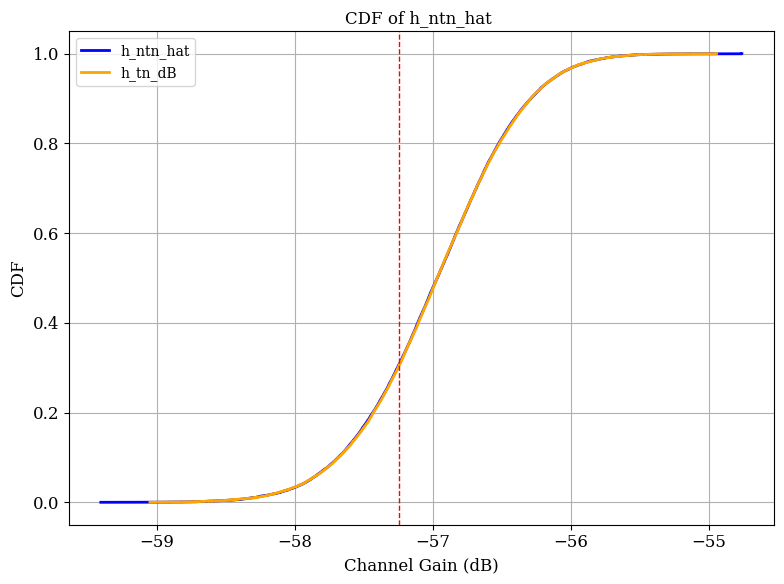

In [44]:
h_ntn_dB_array = np.array(h_ntn_dB_list).flatten()      
h_ntn_dB_array = h_ntn_dB_array[np.isfinite(h_ntn_dB_array)]  
h_ntn_dB_array = np.sort(h_ntn_dB_array)               
cdf_h_ntn_dB = np.arange(1, len(h_ntn_dB_array)+1) / (len(h_ntn_dB_array) )

# ------- Prepare h_tn_dB -------
h_tn_dB_array = np.array(h_tn_dB_list).flatten()
h_tn_dB_array = h_tn_dB_array[np.isfinite(h_tn_dB_array)]
h_tn_dB_array = np.sort(h_tn_dB_array)
cdf_h_tn_dB =  np.arange(1, len(h_tn_dB_array)+1) / (len(h_tn_dB_array))

# ------- Plot -------
plt.figure(figsize=(8, 6))
plt.step(h_ntn_dB_array, cdf_h_ntn_dB, label="h_ntn_hat", linewidth=2, color="blue", where='post')
plt.step(h_tn_dB_array, cdf_h_tn_dB, label="h_tn_dB", linewidth=2, color="orange", where='post')
plt.axvline(x=Threshold, color='red', linestyle='--', linewidth=1)
plt.xlabel("Channel Gain (dB)")
plt.ylabel("CDF")
# plt.title("CDF of h_ntn_hat and h_tn_dB (Filtered -inf)")
plt.title("CDF of h_ntn_hat ")
plt.grid(True)
plt.legend()



plt.tight_layout()
plt.show()

Different Lambda_

In [ ]:
lambda_ranges = [1e10,1e11,1e12] 

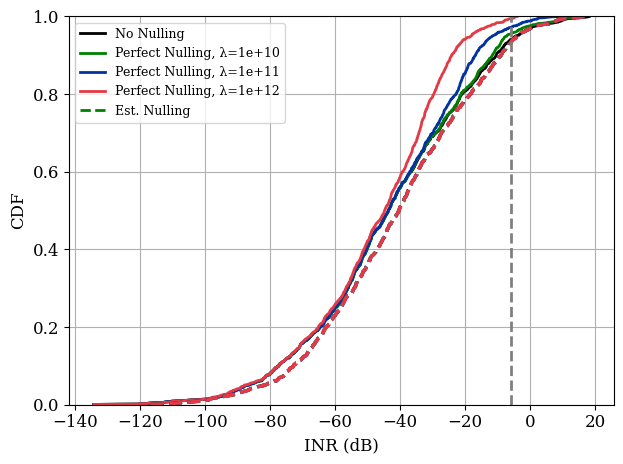

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
    "font.size": 12,
    "legend.fontsize": 9,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

plt.figure()

# 配色
colors = {
    1e10: 'green',
    1e11: '#0033A0',  # 深蓝
    1e12: '#E63946'   # 红
}

# No Nulling（黑色）
inr_array = np.array(inr_list)
inr_array = inr_array[np.isfinite(inr_array)]
inr_sorted = np.sort(inr_array)
if len(inr_sorted) > 0:
    cdf_inr = np.arange(1, len(inr_sorted) + 1) / len(inr_sorted)
    plt.plot(inr_sorted, cdf_inr, linewidth=2, color='black', linestyle='-', label="No Nulling")

# Perfect Nulling（各个 lambda 一条实线，带 label）
for lambda_ in lambda_ranges:
    inr_null = np.array(inr_nulling_dict[lambda_])
    inr_null = inr_null[np.isfinite(inr_null)]
    inr_null_sorted = np.sort(inr_null)
    if len(inr_null_sorted) > 0:
        cdf_null = np.arange(1, len(inr_null_sorted) + 1) / len(inr_null_sorted)
        plt.plot(inr_null_sorted, cdf_null, linewidth=2, linestyle='-',
                 color=colors[lambda_], label=f"Perfect Nulling, λ={lambda_:.0e}")

# Estimated Nulling（画出来但不加 label）
for lambda_ in lambda_ranges:
    inr_null_hat = np.array(inr_nulling_hat_dict[lambda_])
    inr_null_hat = inr_null_hat[np.isfinite(inr_null_hat)]
    inr_null_hat_sorted = np.sort(inr_null_hat)
    if len(inr_null_hat_sorted) > 0:
        cdf_hat = np.arange(1, len(inr_null_hat_sorted) + 1) / len(inr_null_hat_sorted)
        plt.plot(inr_null_hat_sorted, cdf_hat, linewidth=2.5, linestyle='--',
                 color=colors[lambda_])  # 不加 label！

# 添加灰色参考线
plt.axvline(x=-6, color='grey', linestyle='--', linewidth=2)

# 添加手动虚线说明图例
est_nulling_handle = Line2D([0], [0], color='green', linestyle='--', linewidth=2, label='Est. Nulling')
# perf_nulling_handle = Line2D([0], [0], color='green', linestyle='-', linewidth=2, label='Perfect Nulling')
# 添加 legend（自动 + 手动合并）
handles, labels = plt.gca().get_legend_handles_labels()
# handles.append(perf_nulling_handle)
# labels.append('Perfect Nulling')
handles.append(est_nulling_handle)

labels.append('Est. Nulling')
plt.legend(handles=handles, labels=labels, loc='upper left')

# 图形美化
plt.xlabel("INR (dB)")
plt.ylabel("CDF")
plt.grid(True)
# plt.xlim([-70, 25])
plt.ylim([0, 1])
# plt.xticks([-70, -50, -30, -15, -6, 0, 10, 20, 25])

plt.tight_layout()

plt.savefig("../ResultPlot/For GC/inr_cdf.pdf", format="pdf", bbox_inches="tight")
plt.savefig("../ResultPlot/For GC/inr_cdf.png", format="png", bbox_inches="tight")
plt.show()


/tmp/ipykernel_585076/853669011.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


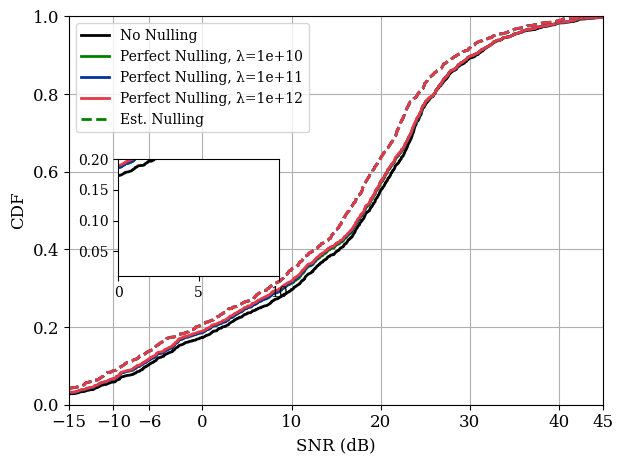

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
    "font.size": 12,
    "legend.fontsize": 10,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})
plt.figure()
main_ax = plt.gca()

# Define consistent colors using colormap
cmap = plt.get_cmap('Dark2')
colors = {lambda_: cmap(i % cmap.N) for i, lambda_ in enumerate(lambda_ranges)}
colors = {
    1e10: 'green',  # vibrant red
    1e11: '#0033A0',  # vibrant red  #E63946
    1e12: '#E63946'  # deep indigo
}
nulling_line_styles = ['--', '-.', (0, (2, 2)), (0, (2, 1, 1, 1))]
# ------- Raw SNR -------
snr_array = np.array(snr_list)
snr_array = snr_array[np.isfinite(snr_array)]
snr_sorted = np.sort(snr_array)
if len(snr_sorted) > 0:
    cdf_snr = np.arange(1, len(snr_sorted) + 1) / len(snr_sorted)
    main_ax.plot(snr_sorted, cdf_snr, label="No Nulling", linewidth=2, color='black', linestyle='-')

# ------- Perfect Nulling -------
for lambda_ in lambda_ranges:
    snr_null = np.array(snr_nulling_dict[lambda_])
    snr_null = snr_null[np.isfinite(snr_null)]
    snr_null_sorted = np.sort(snr_null)

    if len(snr_null_sorted) > 0:
        cdf_snr_null = np.arange(1, len(snr_null_sorted) + 1) / len(snr_null_sorted)
        main_ax.plot(snr_null_sorted, cdf_snr_null,
                     label=f"Perfect Nulling, λ={lambda_:.0e}",
                     linewidth=2, linestyle="-",
                     color=colors[lambda_])

# ------- Estimated Nulling -------
for lambda_ in lambda_ranges:
    snr_null_hat = np.array(snr_nulling_hat_dict[lambda_])
    snr_null_hat = snr_null_hat[np.isfinite(snr_null_hat)]
    snr_null_hat_sorted = np.sort(snr_null_hat)

    if len(snr_null_hat_sorted) > 0:
        cdf_snr_null_hat = np.arange(1, len(snr_null_hat_sorted) + 1) / len(snr_null_hat_sorted)
        main_ax.plot(snr_null_hat_sorted, cdf_snr_null_hat,
                    #  label=f"Est. Nulling (λ={lambda_:.0e})",
                     linewidth=2, linestyle="--",
                     color=colors[lambda_])
        
# 添加手动虚线说明图例
est_nulling_handle = Line2D([0], [0], color='green', linestyle='--', linewidth=2, label='Est. Nulling')
# perf_nulling_handle = Line2D([0], [0], color='green', linestyle='-', linewidth=2, label='Perfect Nulling')
# 获取已有的句柄和标签（No Nulling + 每个 λ 的 Perfect Nulling）
handles, labels = main_ax.get_legend_handles_labels()
# handles.append(perf_nulling_handle)
# labels.append('Perfect Nulling')
# 添加虚线统一说明图例
handles.append(est_nulling_handle)
labels.append('Est. Nulling')

# 添加 legend
main_ax.legend(handles=handles, labels=labels, loc='upper left')
# main_ax.plt.legend(handles=handles, labels=labels, loc='upper left')
# ------- Main plot formatting -------
main_ax.set_xlabel("SNR (dB)")
main_ax.set_ylabel("CDF")
main_ax.grid(True)
# main_ax.legend()
main_ax.set_xlim([-15, 45])
main_ax.set_ylim([0, 1])
main_ax.set_xticks([-15,-10,-6,0,10,20,30,40,45])
# plt.axvline(x=-6, color='black', linestyle='--', linewidth=1)
# ------- Add inset: zoom into 30–50 dB -------
inset_ax = inset_axes(main_ax, width="60%", height="60%", loc='upper left',
                      bbox_to_anchor=(0.08, 0.15, 0.5, 0.5), bbox_transform=main_ax.transAxes)

# Redraw all curves in the inset
inset_ax.plot(snr_sorted, cdf_snr, linewidth=2, color='black', linestyle='-')
for lambda_ in lambda_ranges:
    # Perfect Nulling
    snr_null_sorted = np.sort(np.array(snr_nulling_dict[lambda_]))
    snr_null_sorted = snr_null_sorted[np.isfinite(snr_null_sorted)]
    cdf_snr_null = np.arange(1, len(snr_null_sorted) + 1) / len(snr_null_sorted)
    inset_ax.plot(snr_null_sorted, cdf_snr_null,
                  linewidth=2, linestyle='-', color=colors[lambda_])
    
    # Estimated Nulling
    snr_null_hat_sorted = np.sort(np.array(snr_nulling_hat_dict[lambda_]))
    snr_null_hat_sorted = snr_null_hat_sorted[np.isfinite(snr_null_hat_sorted)]
    cdf_snr_null_hat = np.arange(1, len(snr_null_hat_sorted) + 1) / len(snr_null_hat_sorted)
    inset_ax.plot(snr_null_hat_sorted, cdf_snr_null_hat,
                  linewidth=2, linestyle='--', color=colors[lambda_])

# Set inset range and grid
inset_ax.set_xlim([0, 10])
inset_ax.set_ylim([0.01, 0.2])
inset_ax.grid(False)
inset_ax.tick_params(labelsize=10)  # 控制坐标轴刻度字体大小
# inset_ax.set_xlabel("SNR (dB)", fontsize=9)
# inset_ax.set_ylabel("CDF", fontsize=9)
# Draw connection lines between inset and main plot
# mark_inset(main_ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5")

plt.tight_layout()

plt.savefig("../ResultPlot/For GC/snr_cdf.pdf", format="pdf", bbox_inches="tight")
plt.savefig("../ResultPlot/For GC/snr_cdf.png", format="png", bbox_inches="tight")
plt.show()


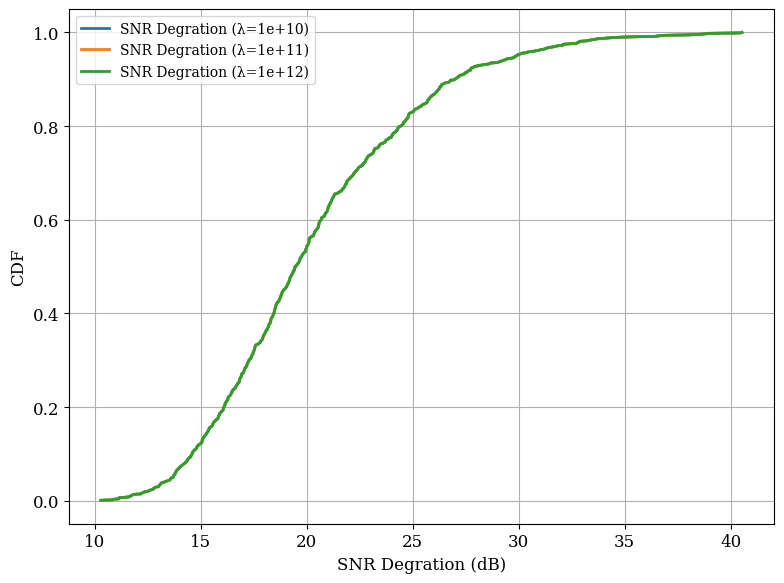

In [ ]:

plt.figure(figsize=(8, 6))

for lambda_ in lambda_ranges:
    degration_list = snr_degration_dict[lambda_]
    degration_array = np.array(degration_list)
    degration_array = degration_array[np.isfinite(degration_array)]
    degration_sorted = np.sort(degration_array)

    if len(degration_sorted) > 0:
        cdf_degration = np.arange(1, len(degration_sorted) + 1) / len(degration_sorted)
        plt.plot(degration_sorted, cdf_degration,
                 label=f"SNR Degration (λ={lambda_:.0e})",
                #  label=f"SNR Degration (λ={lambda_:.0e}, n={len(degration_sorted)})",
                 linewidth=2)

# ---- Plot formatting ----
plt.xlabel("SNR Degration (dB)")
plt.ylabel("CDF")
# plt.title("CDF of SNR Degration for Different λ")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


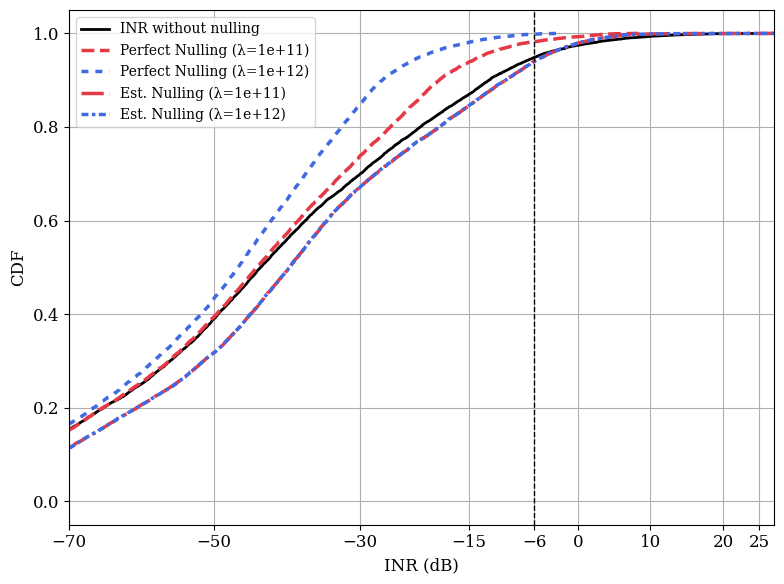

In [ ]:

lambda_ranges = [1e11, 1e12]
plt.figure(figsize=(8, 6))

cmap = plt.get_cmap('Dark2')
colors = {lambda_: cmap(i % cmap.N) for i, lambda_ in enumerate(lambda_ranges)}
colors = {
    1e11: '#E63946',  # vibrant red
    1e12: '#4169E1',  # deep indigo
}
# Raw INR
inr_array = np.array(inr_list)
inr_array = inr_array[np.isfinite(inr_array)]
inr_sorted = np.sort(inr_array)

if len(inr_sorted) > 0:
    cdf_inr = np.arange(1, len(inr_sorted) + 1) / len(inr_sorted)
    plt.plot(inr_sorted, cdf_inr,
             label="INR without nulling",
             linewidth=2, color='black', linestyle='-')

# Define 4 distinct line styles for 2 lambda values (2x Perfect + Est.)
nulling_line_styles = ['--', '-.', (0, (2, 2)), (0, (2, 1, 1, 1))]

# Perfect Nulling
for idx, lambda_ in enumerate(lambda_ranges):
    inr_null = np.array(inr_nulling_dict[lambda_])
    inr_null = inr_null[np.isfinite(inr_null)]
    inr_null_sorted = np.sort(inr_null)

    if len(inr_null_sorted) > 0:
        cdf_null = np.arange(1, len(inr_null_sorted) + 1) / len(inr_null_sorted)
        plt.plot(inr_null_sorted, cdf_null,
                 label=f"Perfect Nulling (λ={lambda_:.0e})",
                 linewidth=2.5,
                 linestyle=nulling_line_styles[2 * idx],
                 color=colors[lambda_])

# Estimated Nulling
for idx, lambda_ in enumerate(lambda_ranges):
    inr_null_hat = np.array(inr_nulling_hat_dict[lambda_])
    inr_null_hat = inr_null_hat[np.isfinite(inr_null_hat)]
    inr_null_hat_sorted = np.sort(inr_null_hat)

    if len(inr_null_hat_sorted) > 0:
        cdf_hat = np.arange(1, len(inr_null_hat_sorted) + 1) / len(inr_null_hat_sorted)
        plt.plot(inr_null_hat_sorted, cdf_hat,
                 label=f"Est. Nulling (λ={lambda_:.0e})",
                 linewidth=2.5,
                 linestyle=nulling_line_styles[2 * idx + 1],
                 color=colors[lambda_])

# Final Touch
plt.xlabel("INR (dB)")
plt.ylabel("CDF")
plt.grid(True)
plt.legend()
plt.axvline(x=-6, color='black', linestyle='--', linewidth=1)
plt.xlim([-70, 27])
plt.xticks([-70, -50, -30, -15, -6, 0, 10, 20, 25])
plt.tight_layout()
plt.show()
